## Recommendation System

Hello to the reader of this notebook! I hope you’re having a great day :)

In this document, I will explain the code I have implemented, outline my plans for future development, and share the thought process behind my approach to solving this case study. Understanding the mentality and methodology behind problem-solving is more valuable to me than just the implementation itself, especially in the initial stages.

Due to time constraints and the tasks that I responsible on my side, I might not implement everything I have in mind. However, I will explain those parts in the comments section.

Let's get started 🚀🚀🚀


In [218]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train.parquet


In [219]:
import ast
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

1. Datamızı başlangıç olarak inceleyilim

In [220]:
# Start with reading the data
df = pd.read_parquet('/kaggle/input/train.parquet')

# and deep dive to first 5 index
df.head()

,date,userId,sessionId,pageType,itemId,category,productPrice,oldProductPrice
0,2019-08-05 19:30:37,00172f1d9a71e9a8de0aa34288a6b19b,e8167c23f8ac2f9be979c32380e0fc2b7e94941e917d30...,productDetail,83472aea4051c00d031b01ff42ef73fc,"[""kadın çanta"",""omuz askılı çanta""]",622.0,1220.0
1,2019-08-31 16:53:55,00172f1d9a71e9a8de0aa34288a6b19b,c7f54acdf56e2d7539ffa59107b9017c2a8164495df909...,category,[],"[""seyahat samsonite"",""laptop çantası""]",NaN,NaN
2,2019-08-31 16:53:29,00172f1d9a71e9a8de0aa34288a6b19b,c7f54acdf56e2d7539ffa59107b9017c2a8164495df909...,main,[],[],NaN,NaN
3,2019-08-31 16:53:43,00172f1d9a71e9a8de0aa34288a6b19b,c7f54acdf56e2d7539ffa59107b9017c2a8164495df909...,category,[],"[""seyahat samsonite"",""laptop çantası""]",NaN,NaN
4,2019-08-31 16:54:13,00172f1d9a71e9a8de0aa34288a6b19b,c7f54acdf56e2d7539ffa59107b9017c2a8164495df909...,productDetail,d6afa22ab475d41e7dc9b721f3f795ad,"[""seyahat samsonite"",""laptop çantası""]",389.0,389.0


In [221]:
df = df.sort_values(by=['sessionId', 'date'])

# Check Data Types

***df.describe()*** will give us insight about the numerical values, which are productPrice and oldProductPrice. Why this important ? Because according to the model that we are going to use these price values can be dominant one to other,or to the features in other columns.

Imagine we make one hot encoding. The value for that category will be 1 or 0 while the price is max 8499.160000

To solve this a normalization can be make, or can be check the distrubution of the data and eliminate the outliers if any or alter the distribution to normal distribution.

***df.info()*** will give us insight about the types, or the null values if any as np.nan type.

we see that the date column needs to convert to Date Object and category needs to be list type.



In [222]:
df.describe()

,productPrice,oldProductPrice
count,217985.000000,2.179850e+05
mean,548.120602,1.648211e+13
std,703.398175,3.644781e+15
min,9.900000,9.900000e+00
25%,195.000000,4.980000e+02
50%,289.000000,6.580000e+02
75%,629.000000,1.098000e+03
max,8499.160000,8.505585e+17


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691842 entries, 466412 to 153277
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             691842 non-null  object 
 1   userId           691842 non-null  object 
 2   sessionId        691842 non-null  object 
 3   pageType         691842 non-null  object 
 4   itemId           691842 non-null  object 
 5   category         691842 non-null  object 
 6   productPrice     217985 non-null  float64
 7   oldProductPrice  217985 non-null  float64
dtypes: float64(2), object(6)
memory usage: 47.5+ MB


In [224]:
# sometimes arrays, list also seem as object, let's double check
df.dtypes
df['category'].apply(type).head()
df['date'].apply(type).head()

466412    <class 'str'>
466411    <class 'str'>
466413    <class 'str'>
513564    <class 'str'>
513563    <class 'str'>
Name: date, dtype: object

In [225]:
df['category'] = df['category'].apply(ast.literal_eval)
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date               datetime64[ns]
userId                     object
sessionId                  object
pageType                   object
itemId                     object
category                   object
productPrice              float64
oldProductPrice           float64
dtype: object

In [226]:
df['category'].apply(type).head()


466412    <class 'list'>
466411    <class 'list'>
466413    <class 'list'>
513564    <class 'list'>
513563    <class 'list'>
Name: category, dtype: object

# Let's do some EDA (Explotary Data Analysis)

This part is crucial because the insights we gain here will directly inform our feature engineering process. EDA helps us understand the data deeply and uncover important patterns and relationships.


In [227]:
unique_categories = df['category'].explode().nunique()
print(f'Unique kategori sayısı: {unique_categories}')
unique_product_ids = df['itemId'].explode().nunique()
print(f'Unique ürün ID si sayısı: {unique_product_ids}')


Unique kategori sayısı: 209
Unique ürün ID si sayısı: 15329


In [228]:
unique_sessions = df['sessionId'].nunique()
print(f'Unique session sayısı: {unique_sessions}')

unique_users = df['userId'].nunique()
print(f'Unique kullanıcı sayısı: {unique_users}')

Unique session sayısı: 84104
Unique kullanıcı sayısı: 30133


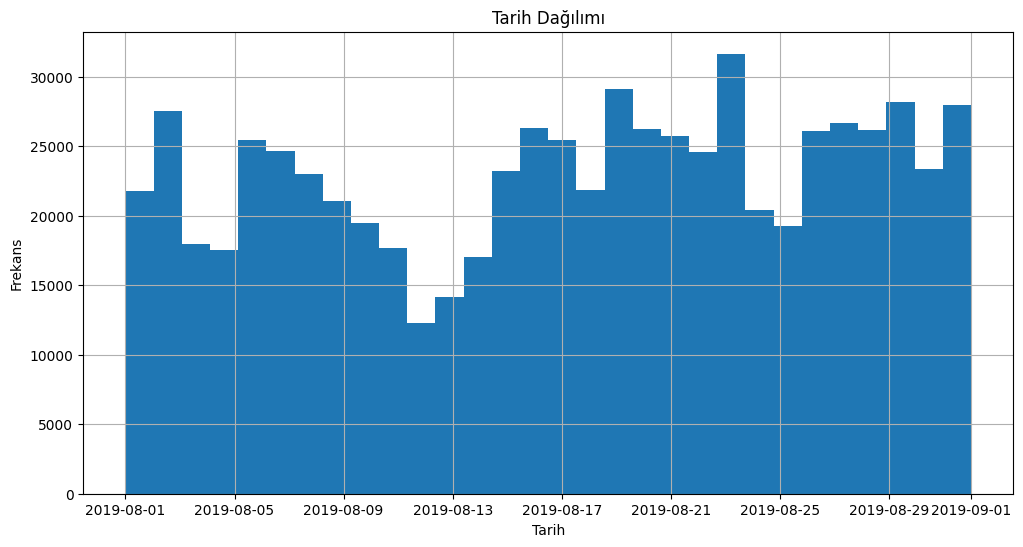

In [229]:
# Tarih dağılımını histogram ile gösterelim
df['date'].hist(bins=30, figsize=(12, 6))
plt.xlabel('Tarih')
plt.ylabel('Frekans')
plt.title('Tarih Dağılımı')
plt.show()


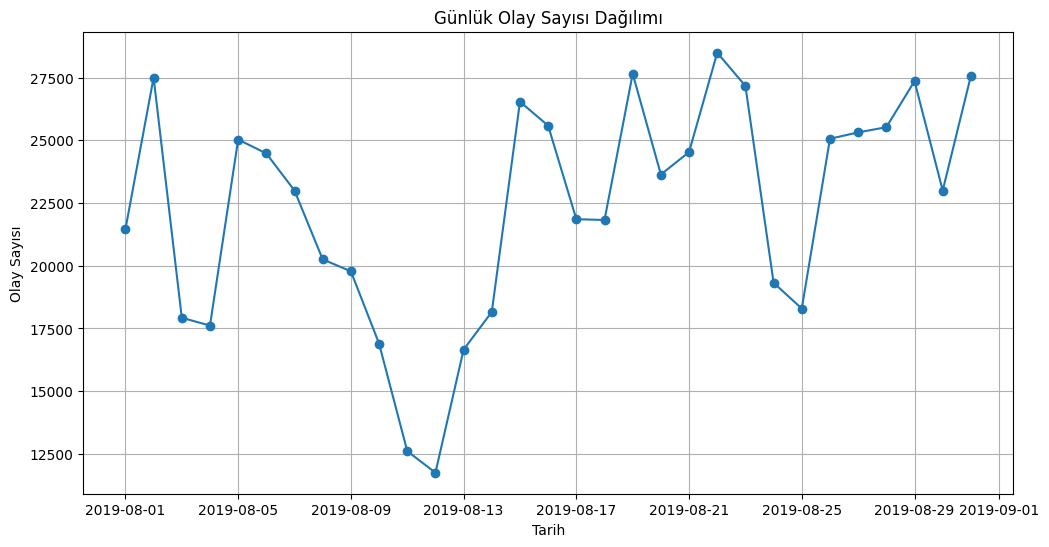

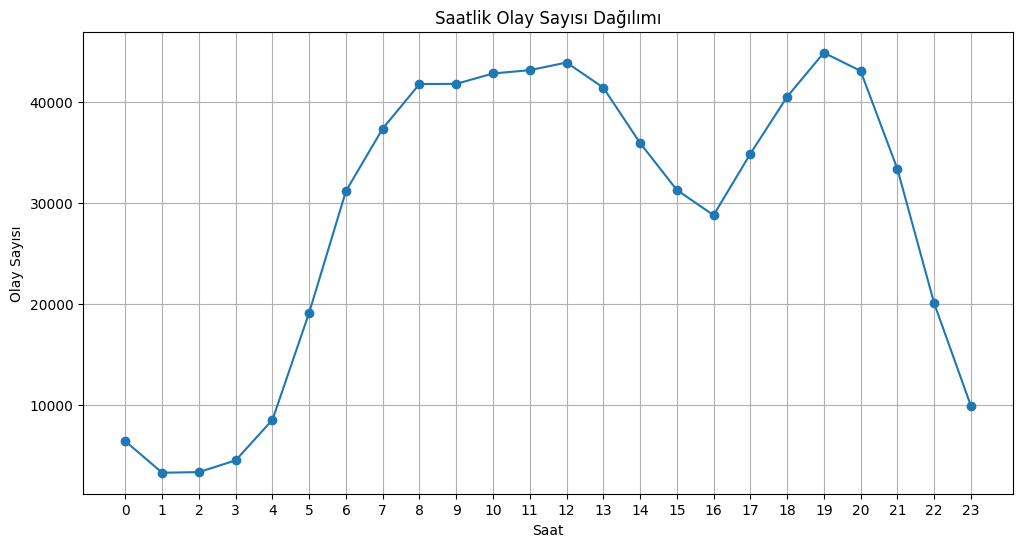

In [230]:
# Zaman serisi analizi - olayların günlük dağılımı
df['date'] = pd.to_datetime(df['date'])
dateDf =df.copy()
dateDf.set_index('date', inplace=True)
dateDf = dateDf.sort_values(by='date')

# Günlük olay sayısı
daily_events = dateDf.resample('D').size()
daily_events = daily_events.reindex(pd.date_range(start=daily_events.index.min(), end=daily_events.index.max(), freq='D'), fill_value=0)
plt.figure(figsize=(12, 6))
plt.plot(daily_events.index, daily_events.values, marker='o')
plt.xlabel('Tarih')
plt.ylabel('Olay Sayısı')
plt.title('Günlük Olay Sayısı Dağılımı')
plt.grid(True)
plt.show()

# Saatlik olay sayısı
hourly_events = dateDf.resample('h').size()
hourly_events = hourly_events.groupby(hourly_events.index.hour).sum()
plt.figure(figsize=(12, 6))
plt.plot(hourly_events.index, hourly_events.values, marker='o')
plt.xticks(range(0, 24)) 
plt.xlabel('Saat')
plt.ylabel('Olay Sayısı')
plt.title('Saatlik Olay Sayısı Dağılımı')
plt.grid(True)
plt.show()

pageType
category         344349
productDetail    287731
main              40367
cart              18790
success             605
Name: count, dtype: int64


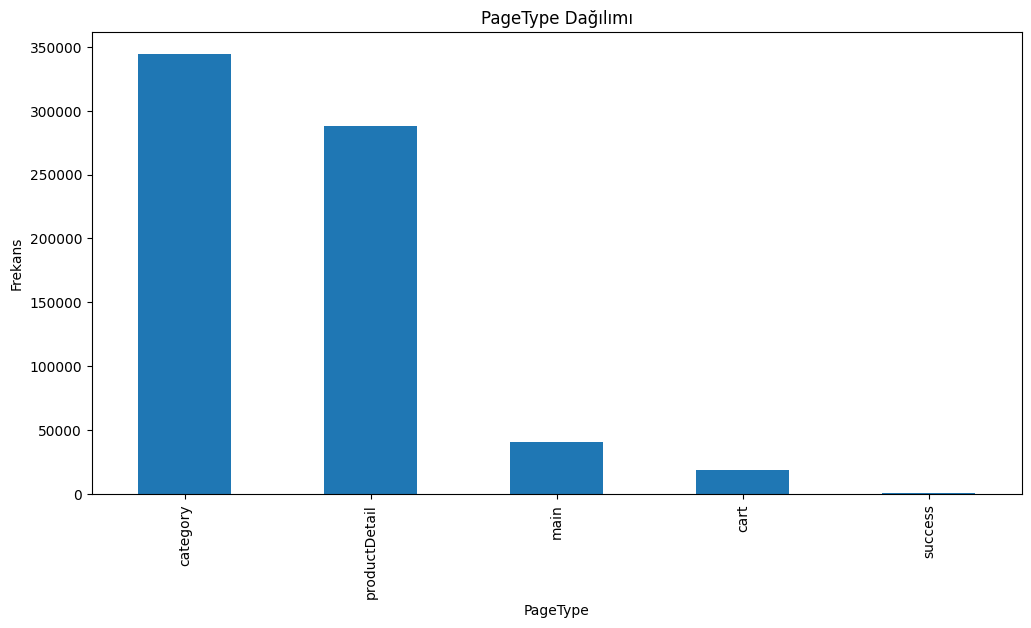

In [231]:
# PageType dağılımı
page_type_counts = df['pageType'].value_counts()
print(page_type_counts)

# PageType dağılımını görselleştirelim
page_type_counts.plot(kind='bar', figsize=(12, 6))
plt.xlabel('PageType')
plt.ylabel('Frekans')
plt.title('PageType Dağılımı')
plt.show()


In [232]:
# Kategori dağılımı
category_counts = df['category'].explode().value_counts()
pd.set_option('display.max_rows',20)

print(category_counts)


category
kadın ayakkabi               293986
erkek ayakkabı                74789
günlük ayakkabı               73530
sandalet                      69072
kadın çanta                   67258
                              ...  
leather skirt                     1
travel american tourister         1
여행 삼소 나이트                         1
yengec burcu                      1
accessories                       1
Name: count, Length: 209, dtype: int64


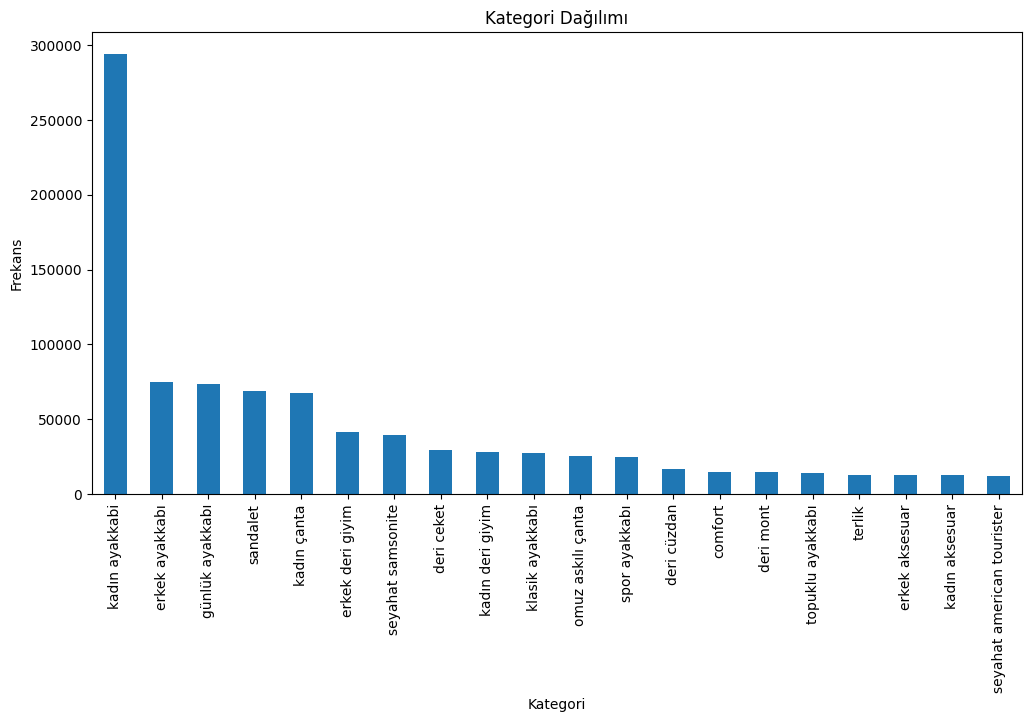

In [233]:
# Kategori dağılımını görselleştirelim
category_counts.head(20).plot(kind='bar', figsize=(12, 6))
plt.xlabel('Kategori')
plt.ylabel('Frekans')
plt.title('Kategori Dağılımı')
plt.show()

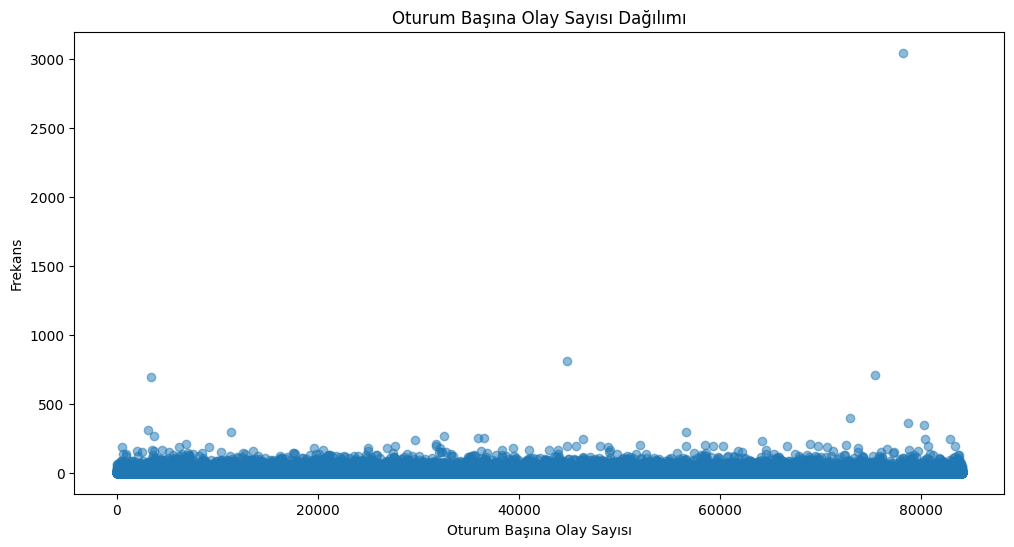

In [234]:
session_event_counts = df.groupby('sessionId').size()
plt.figure(figsize=(12, 6))
plt.scatter(range(len(session_event_counts)), session_event_counts, alpha=0.5)
plt.xlabel('Oturum Başına Olay Sayısı')
plt.ylabel('Frekans')
plt.title('Oturum Başına Olay Sayısı Dağılımı')
plt.show()

***Wow, some sessions has nearly 1000 events !!! Some clients really want to buy that product***

But wait look below, some sessions duration has more than 17500 minutes, I might have a bug on my code, because on the case-study indicated that one session is max 30 minutes or reset on midnight. let's get the dates of the max duration session to double check.

Also this might be an error, some events on that session might be doubled or triplet by mistake. This can be discussed and handle according to that.

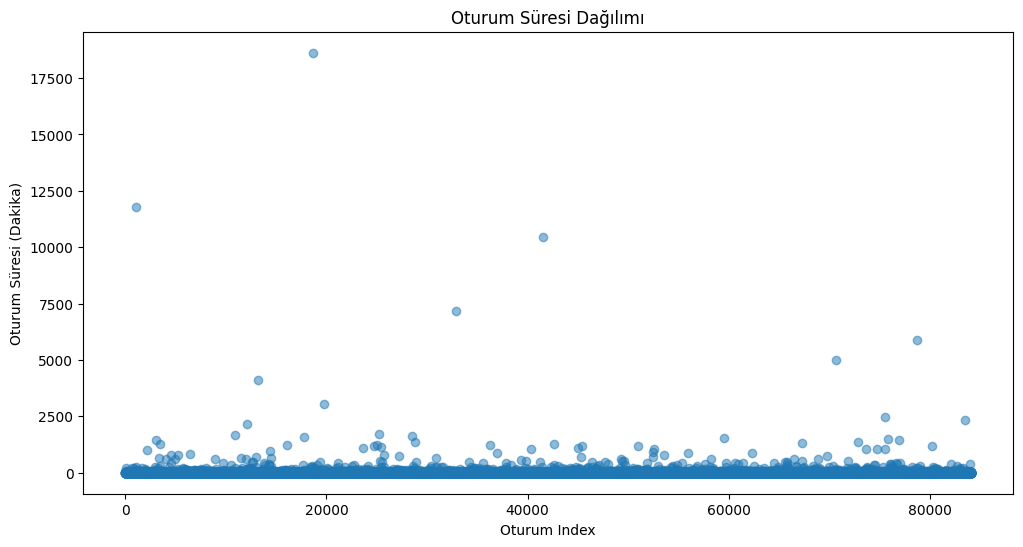

In [235]:
import matplotlib.pyplot as plt

# Oturum süresi
session_durations = df.groupby('sessionId')['date'].apply(lambda x: (x.max() - x.min()).total_seconds() / 60)

# Scatter plot grafiği
plt.figure(figsize=(12, 6))
plt.scatter(range(len(session_durations)), session_durations, alpha=0.5)
plt.xlabel('Oturum Index')
plt.ylabel('Oturum Süresi (Dakika)')
plt.title('Oturum Süresi Dağılımı')
plt.show()


In [236]:
session_durations.max()

18625.95

In [237]:
sessions_larger_30_minutes = session_durations[session_durations >= 30].index

# Bu oturumların başlangıç ve bitiş tarihlerini bulma
session_start_end = df[df['sessionId'].isin(sessions_larger_30_minutes)].groupby('sessionId')['date'].agg(['min', 'max'])

session_start_end

,min,max
sessionId,,
000c2eb5bc98c18c8cac2c5504b1c41968da00963319a65d3b616dcc780e4c41,2019-08-31 12:00:04,2019-08-31 12:45:43
001554c8b64a99b4dcfcab5132860f517e7b90a5f1999300d1a475ff4459e462,2019-08-19 10:38:40,2019-08-19 11:51:10
0035e6611f3bfec885c21512b76a4b6312632e9e6415dc826ae555a5f93b3613,2019-08-07 10:04:42,2019-08-07 13:53:25
003e9c34a92e4d6b06b99f3973bb6b0e98a446f78a2f3272213a92494ad3fc1c,2019-08-13 08:28:49,2019-08-13 09:03:01
0072f45bc04cd10cd6d41a867c4e8f75ed48cf1a68a414916c3e1088fd877792,2019-08-25 17:44:26,2019-08-25 18:19:34
...,...,...
ff63d205c66bc53378175cb87cd5a528d65fd248a2af42296e1ceb6b76a77e7b,2019-08-11 08:32:08,2019-08-11 09:07:19
ff8134f1094eb3f201524af664aaaf992cf4d4618a686c942a888713b978e0a3,2019-08-04 17:48:13,2019-08-04 18:31:44
ff93ee608ca6dfe85bd4370c60ba3a0c63366c7ad8e77c9cd56a296aeae7ce9b,2019-08-31 19:47:24,2019-08-31 20:26:32


Interesting there are 2684 sessions which has duration longer than 30 minutes.


# Funnel analysis

Funnel analysis is a method used to understand the stages a user goes through before completing a desired action, such as making a purchase. It helps identify where users drop off in the process and provides insights into potential areas for improvement. By analyzing these stages, we can optimize the user journey and increase conversion rates.

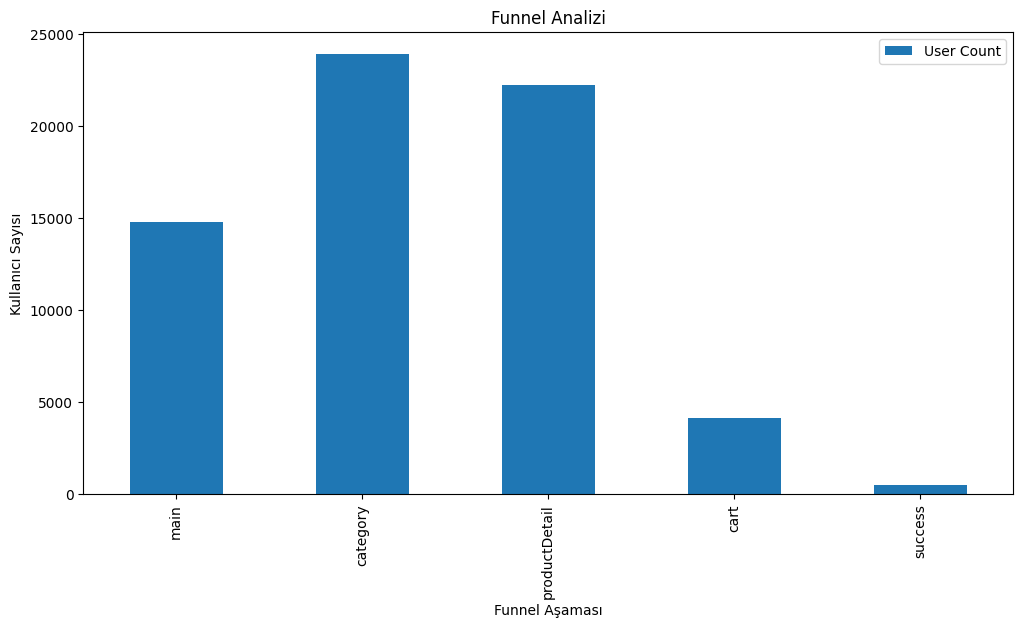

In [238]:
# Funnel aşamaları
funnel_stages = ['main', 'category', 'productDetail', 'cart', 'success']

# Funnel aşamalarındaki kullanıcı sayısı
funnel_counts = {stage: df[df['pageType'] == stage]['userId'].nunique() for stage in funnel_stages}

# Funnel analizi görselleştirme
funnel_df = pd.DataFrame.from_dict(funnel_counts, orient='index', columns=['User Count'])
funnel_df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Funnel Aşaması')
plt.ylabel('Kullanıcı Sayısı')
plt.title('Funnel Analizi')
plt.show()


Here we can take a closer look at why people are adding products to their carts and what factors lead them to make a purchase. By understanding these behaviors, we can create new features that not only suggest products they're likely interested in but also predict what they are more likely to buy. This way, we can tailor recommendations that have a higher chance of leading to a purchase.

userId
0001d86ea81e6eef12cebaa1dcbdadc2                                      [productDetail]
0002354a6405eccef3b1eb4e90b79307    [main, category, category, category, category,...
00039522226dae20808c3f135adc9626    [category, category, category, category, categ...
0008e8e8ed32d8a1be7adf0da1a42314                                     [main, category]
000a53fe09a2a3decd11b6b30d703b9c    [productDetail, productDetail, productDetail, ...
Name: pageType, dtype: object


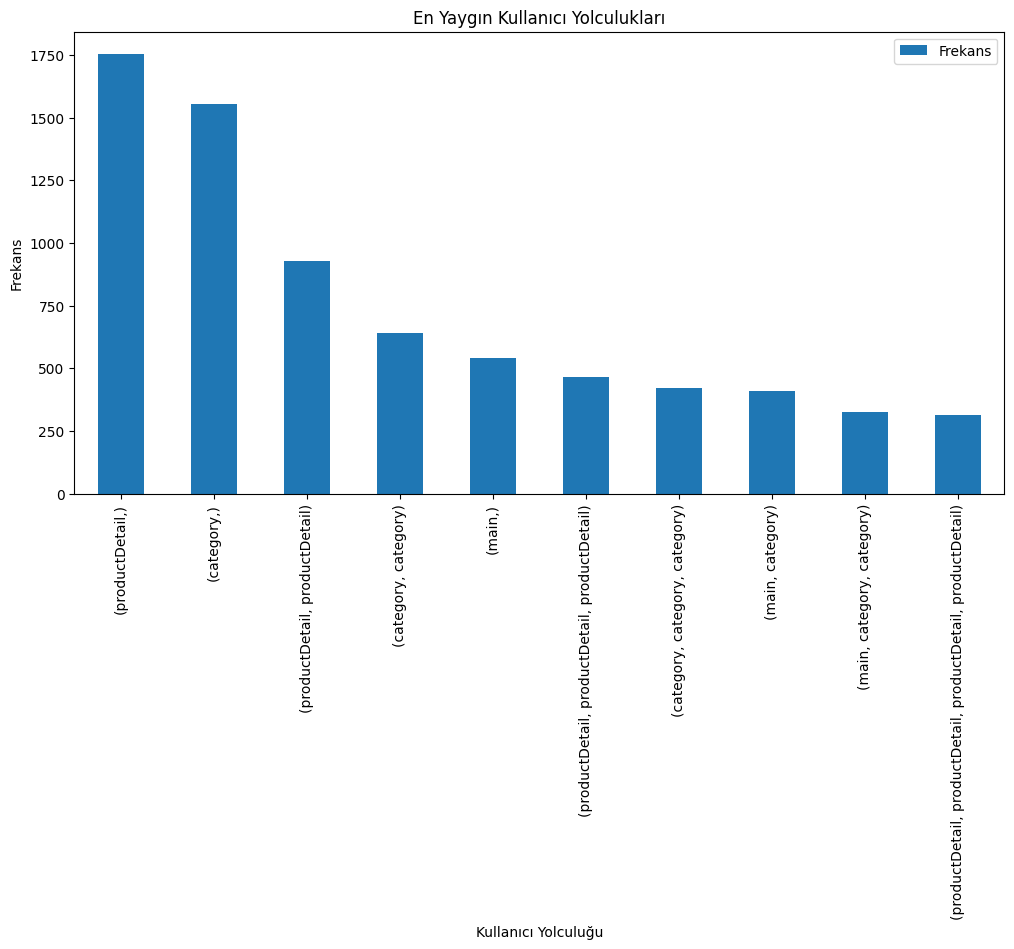

In [239]:
df = df.sort_values(by=['userId', 'date'])

user_journeys = df.groupby('userId')['pageType'].apply(list)

print(user_journeys.head())

from collections import Counter
import matplotlib.pyplot as plt

# Findind the most common journey
journey_counts = Counter(tuple(journey) for journey in user_journeys)

# Visualization of most common 10 user
common_journeys = journey_counts.most_common(10)
common_journeys_df = pd.DataFrame(common_journeys, columns=['Yolculuk', 'Frekans'])

# Visualization
common_journeys_df.plot(kind='bar', x='Yolculuk', y='Frekans', figsize=(12, 6))
plt.xlabel('Kullanıcı Yolculuğu')
plt.ylabel('Frekans')
plt.title('En Yaygın Kullanıcı Yolculukları')
plt.show()



# What is Conversion Rate?

The conversion rate is the percentage of specific actions that lead to a desired outcome. In the context of e-commerce, a conversion typically refers to a purchase. We look at questions like how many visitors to a website add products to their cart, and of those, how many complete the purchase.

For example, if there are 100 sessions on a website and 20 of them result in a purchase, the conversion rate is 20%.

In [240]:
# Her oturum için satın alma olup olmadığını kontrol edelim
df['purchase'] = df['pageType'] == 'success'

# Oturum başına dönüşüm oranını hesaplayalım
session_purchases = df.groupby('sessionId')['purchase'].any()
conversion_rate = session_purchases.mean()
print(f'Dönüşüm Oranı: {conversion_rate * 100:.2f}%')



Dönüşüm Oranı: 0.65%


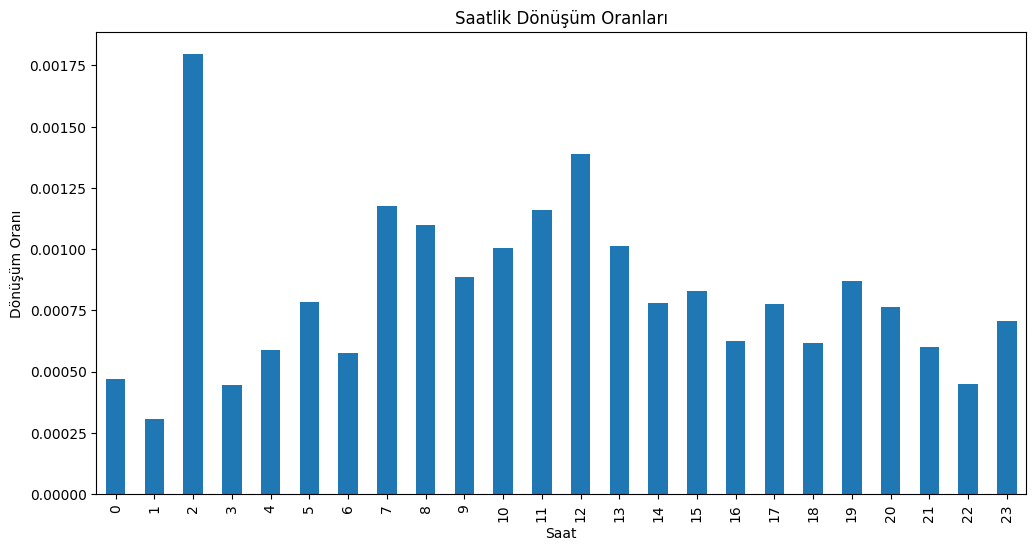

In [241]:
# Zaman dilimlerine göre dönüşüm oranı
df['hour'] = df['date'].dt.hour
hourly_conversion = df.groupby('hour')['purchase'].mean()

# Saatlik dönüşüm oranlarını görselleştirelim
hourly_conversion.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Saat')
plt.ylabel('Dönüşüm Oranı')
plt.title('Saatlik Dönüşüm Oranları')
plt.show()


In [242]:
# Kullanıcıların tekrar ziyaret oranını hesaplayalım
user_visits = df.groupby('userId')['sessionId'].nunique()
repeat_visitors = user_visits[user_visits > 1].count()
total_users = user_visits.count()
repeat_visit_rate = repeat_visitors / total_users
print(f'Tekrar Ziyaret Oranı: {repeat_visit_rate * 100:.2f}%')

Tekrar Ziyaret Oranı: 51.38%


pageType
cart             0.137291
category         0.793914
main             0.490890
productDetail    0.737198
success          0.015564
Name: userId, dtype: float64


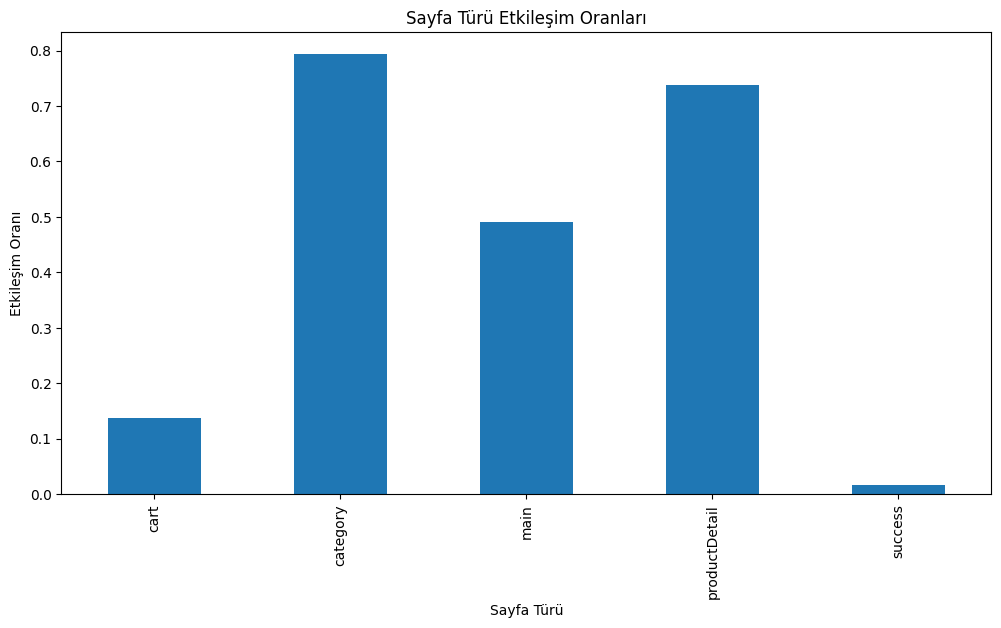

In [243]:
# Her sayfa türü için etkileşim oranlarını hesaplayalım
interaction_rates = df.groupby('pageType')['userId'].nunique() / unique_users
print(interaction_rates)

# Etkileşim oranlarını görselleştirelim
interaction_rates.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Sayfa Türü')
plt.ylabel('Etkileşim Oranı')
plt.title('Sayfa Türü Etkileşim Oranları')
plt.show()


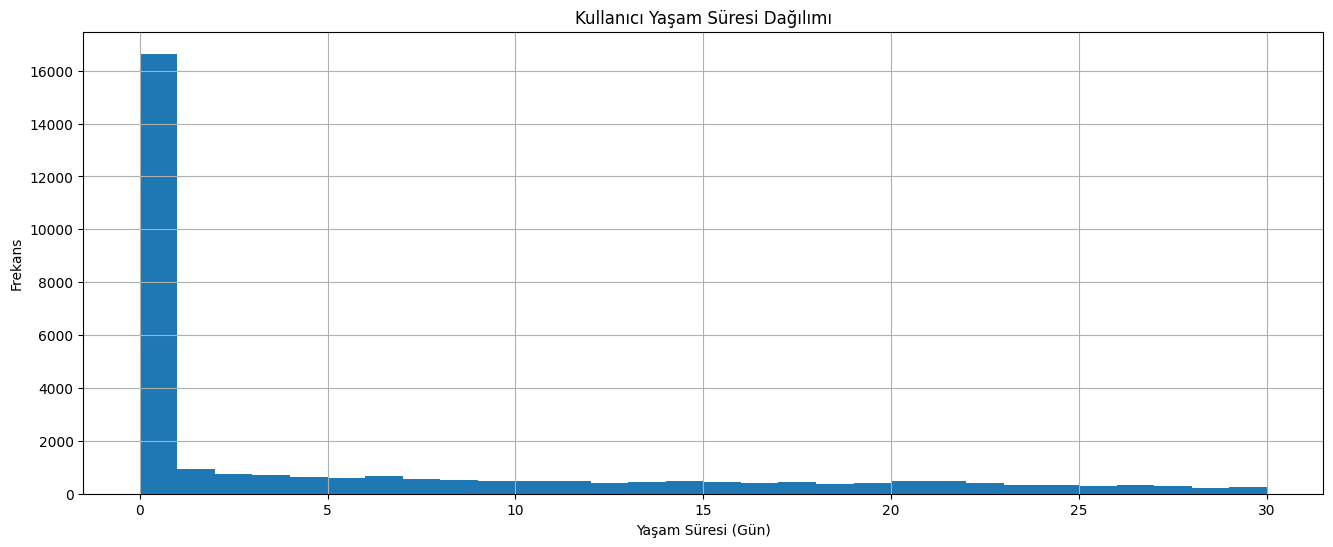

In [244]:
# Kullanıcıların ilk ve son etkinlik tarihlerini belirleyelim
user_lifecycle = df.groupby('userId')['date'].agg(['min', 'max'])

# Kullanıcı yaşam süresini hesaplayalım (gün cinsinden)
user_lifecycle['lifecycle_days'] = (user_lifecycle['max'] - user_lifecycle['min']).dt.days

# Yaşam süresi dağılımı
user_lifecycle['lifecycle_days'].hist(bins=30, figsize=(16,6))
plt.xlabel('Yaşam Süresi (Gün)')
plt.ylabel('Frekans')
plt.title('Kullanıcı Yaşam Süresi Dağılımı')
plt.show()


# Cohort Analysis

Cohort analysis is a way to track and study the behavior of groups of users who joined to the website at the same time. This helps you understand how engaged they are over time.

First we look at when users first signed up or interacted with the site. This is the users starting point than we group users based on their signup dates. For instance, all users who signed up in January 2023 would be in the same cohort. After that we create a table that shows how active each cohort is over time. For example, see how users who signed up in January 2023 behave in February, March, and so on.

This analysis might be helpful since on the categories we saw spesific discount categories which may for only spesific dates.


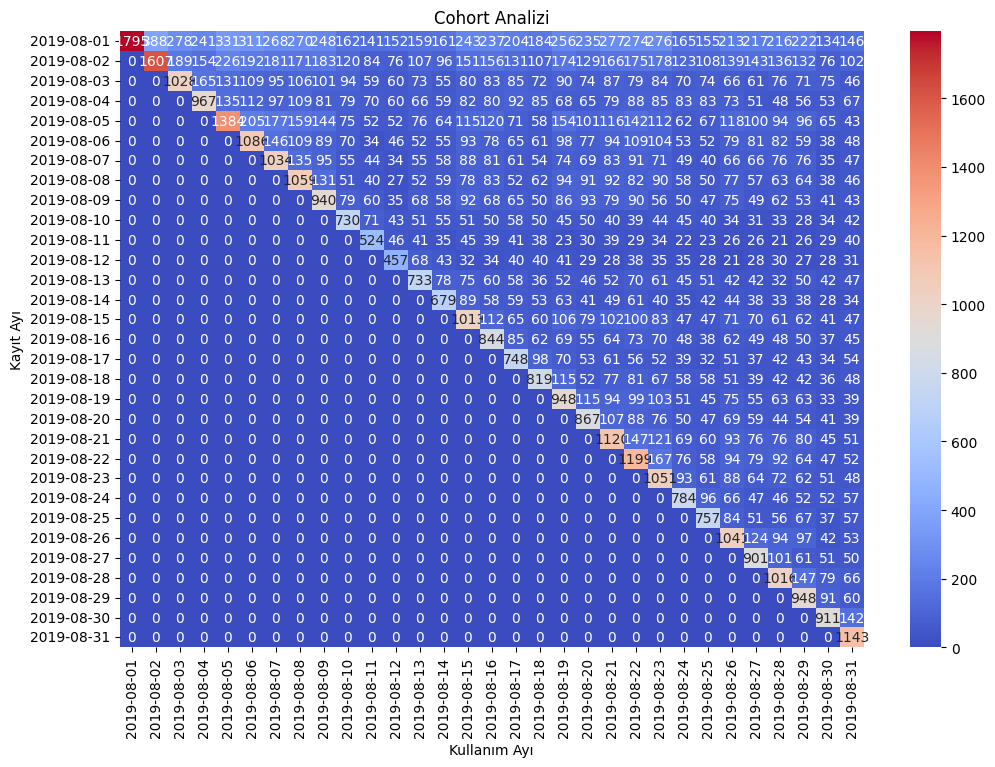

In [245]:
# LETS find the fist sign-in date of the users 
df['signup_date'] = df.groupby('userId')['date'].transform('min')
df['cohort'] = df['signup_date'].dt.to_period('D')

# Creating the cohort table
cohort_data = df.groupby(['cohort', df['date'].dt.to_period('D')])['userId'].nunique().unstack().fillna(0)

# and visalization of it
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_data, annot=True, fmt='.0f', cmap='coolwarm')
plt.xlabel('Kullanım Ayı')
plt.ylabel('Kayıt Ayı')
plt.title('Cohort Analizi')
plt.show()


### Distribution of the Old Product Price and Product Price

#### Why is this important?

Large differences in scale can cause models to give more importance to higher values, potentially skewing the results. To achieve higher accuracy, we need to handle the max, min values, and the overall distribution of the features.

Below, you can see the distribution of `productPrice` and `oldProductPrice`. Both distributions are very skewed, meaning they have a long tail on one side.

Here are some solutions we can use to address this issue:

#### Log Transformation
Log transformation helps reduce the impact of outliers and compresses the range of values. This makes the distribution more uniform and less skewed.

#### Standardization
Standardization scales the data based on the mean and standard deviation, ensuring that the transformed feature has a mean of 0 and a standard deviation of 1. This method is suitable for most scenarios, especially when the data follows a normal distribution.

#### Robust Scaling
Robust scaling uses the median and the interquartile range (IQR) to scale the data, making it less sensitive to outliers. This method is best when dealing with outliers and when the data doesn't follow a normal distribution.

By applying these methods, we can normalize our data and ensure our model performs better.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


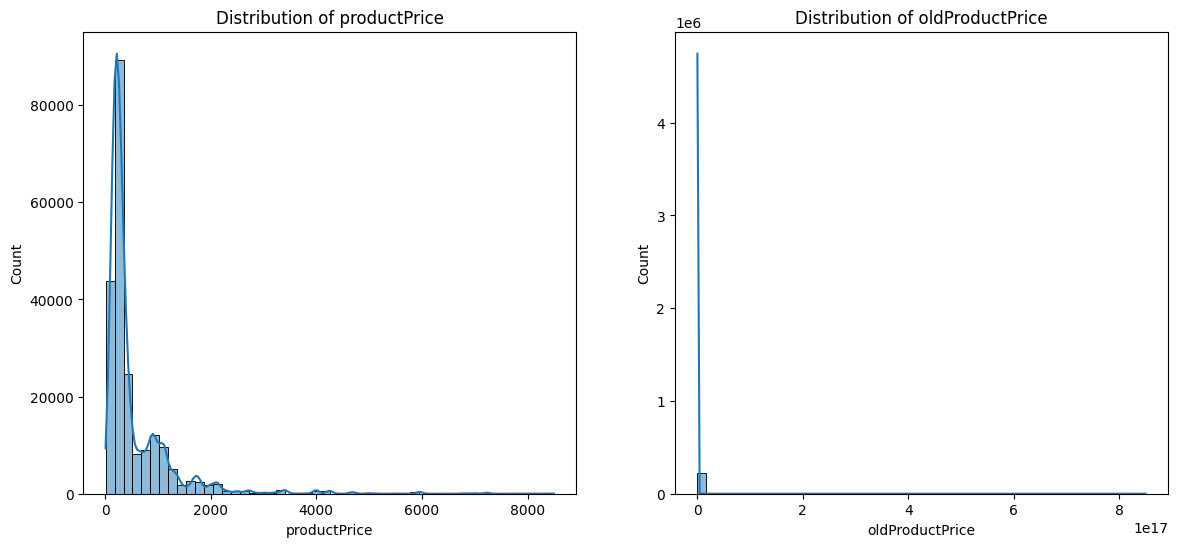

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['productPrice'], bins=50, kde=True)
plt.title('Distribution of productPrice')

plt.subplot(1, 2, 2)
sns.histplot(df['oldProductPrice'], bins=50, kde=True)
plt.title('Distribution of oldProductPrice')

plt.show()

Our data appears to be skewed, particularly the oldProductPrice. Let's confirm this using pandas to calculate skewness.

Here's how we interpret the skewness values:

* Skewness > 1: Highly skewed (consider log transformation).
* 0.5 < Skewness < 1: Moderately skewed (consider log transformation or robust scaling).
* Skewness < 0.5: Approximately symmetric (standardization might be suitable).

By analyzing the skewness, we can choose the most appropriate method to normalize our data.

In [247]:
skew_productPrice = df['productPrice'].skew()
skew_oldProductPrice = df['oldProductPrice'].skew()

print(f'Skewness of productPrice: {skew_productPrice}')
print(f'Skewness of oldProductPrice: {skew_oldProductPrice}')


Skewness of productPrice: 4.192667853522217
Skewness of oldProductPrice: 233.1934789965241


In [248]:
#lets analys which discount rated products success and cart and clicked !! 

# Let's Start with Feature Engineering

Feature engineering is a really important part of machine learning. Often, people focus on improving the model architecture, but if you have a Ferrari, you can't expect it to run well on cheap gas, right?

It's the same with our models – we need to create meaningful data. This means altering the current data and using both active and passive datasets to come up with useful features.

For instance, take `productPrice` and `oldProductPrice`. Using these, we can create new features like `discountAmount` or `discountPercentage`. Maybe one of these factors will be the reason a customer decides to buy a product. We need to dig deeper, run correlation and performance tests, and figure out which features are the most useful.

So, let's get started and see how we can make our data work better for us!


### Important

While preparing for the AWS Machine Learning Practitioner certification, I learned about a crucial concept called **data leakage**.

**Data leakage** occurs when information from outside the training dataset is used to create the model. This can happen in several ways, such as when test data inadvertently influences training data or when future information is used to predict past events. This often leads to overly optimistic performance metrics during validation, but poor performance in a real-world production environment.

One common cause of data leakage is improper feature engineering. For instance, if you calculate statistics like the median on the entire dataset before splitting it into training and test sets, you risk leaking information from the test set into the training process. This means your model might perform well on the holdout data (test and validation sets), but fail to generalize to new, unseen data.

### How to Avoid Data Leakage

To avoid data leakage, always perform the train-test split before any feature engineering. This ensures that no information from the test set can influence the training process. By doing this, you can be more confident that your model's performance metrics are valid and that it will perform well in production.

# Transforming Page Types

before train test split I would like to handle encoding because after train split there might be some problem due to lack of some categories in train or test data. This can be also fixed but I want to go with this way. 

I've decided to represent the page types using one-hot encoding. After considering the funnel analysis and the interaction rates for each page type, I concluded that no single page is inherently more important than the others.

**Label Encoding:** This could imply a hierarchy, suggesting that some pages are more important than others. For instance, while the success page is crucial because it indicates a purchase, using label encoding might not accurately reflect the independent nature of user interactions across different pages.

**One-Hot Encoding:** This method treats each page type as an independent feature. It's particularly useful when there's no clear ordinal relationship between categories. This way, the model doesn't infer any unintended order among the stages. Additionally, using one-hot encoding, the model can still learn the importance and relationships of the different pages.


In [249]:
# Before train testy lets do 

# this tooks long time like 10 minutes so I am commenting for now

"""
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
print("OneHotEncoder'ı fit etme...")
page_types = df['pageType'].unique().tolist()
one_hot_encoder_pageType = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoder_pageType.fit(pd.DataFrame(page_types, columns=['pageType']))
print("OneHotEncoder fit işlemi tamamlandı.")

# tqdm ile progress bar kullanma
tqdm.pandas(desc="PageType'ları encode etme")

# Her bir session için pageType'ları one-hot encode etme ve birleştirme
def encode_page_type(page_type):
    encoded = one_hot_encoder_pageType.transform(pd.DataFrame([page_type], columns=['pageType']))
    return encoded[0]

print("PageType'ları encode etmeye başlama...")
df['one_hot_encoded'] = df['pageType'].progress_apply(encode_page_type)
print("PageType'ların encode işlemi tamamlandı.")

# One-hot encoded özellikleri ayrı sütunlara ayırma
print("One-hot encoded özellikleri ayrı sütunlara ayırma...")
encoded_df = pd.DataFrame(df['one_hot_encoded'].tolist(), index=df.index, columns=one_hot_encoder_pageType.get_feature_names_out(['pageType']))
print("One-hot encoded özellikler ayrıldı.")

# Orijinal DataFrame'e encoded özellikleri ekleme
df = pd.concat([df.drop(columns=['one_hot_encoded', 'pageType']), encoded_df], axis=1)

print("One-Hot Encoded DataFrame:")
df
"""

'\nfrom sklearn.preprocessing import OneHotEncoder\nfrom tqdm import tqdm\nprint("OneHotEncoder\'ı fit etme...")\npage_types = df[\'pageType\'].unique().tolist()\none_hot_encoder_pageType = OneHotEncoder(sparse_output=False, handle_unknown=\'ignore\')\none_hot_encoder_pageType.fit(pd.DataFrame(page_types, columns=[\'pageType\']))\nprint("OneHotEncoder fit işlemi tamamlandı.")\n\n# tqdm ile progress bar kullanma\ntqdm.pandas(desc="PageType\'ları encode etme")\n\n# Her bir session için pageType\'ları one-hot encode etme ve birleştirme\ndef encode_page_type(page_type):\n    encoded = one_hot_encoder_pageType.transform(pd.DataFrame([page_type], columns=[\'pageType\']))\n    return encoded[0]\n\nprint("PageType\'ları encode etmeye başlama...")\ndf[\'one_hot_encoded\'] = df[\'pageType\'].progress_apply(encode_page_type)\nprint("PageType\'ların encode işlemi tamamlandı.")\n\n# One-hot encoded özellikleri ayrı sütunlara ayırma\nprint("One-hot encoded özellikleri ayrı sütunlara ayırma...")\nenc

In the previous section, I discussed the importance of preventing **data leakage** to ensure a realistic and robust evaluation of recommendation systems. 

- Data leakage occurs when information from the test set unintentionally influences the training process, skewing the results. To avoid this, we split the data based on unique user interactions, ensuring that users in the training set are completely separate from those in the test set. 

- This separation prevents the model from indirectly learning about test data, thus maintaining the integrity of the evaluation. 

- In real-world scenarios, recommendation systems often encounter new users (cold-start problem) who were not seen during training. By splitting the data based on unique users, we can effectively simulate this scenario during evaluation. 

- Consequently, the model’s performance metrics (e.g., precision, recall, AUC) will better reflect its ability to generalize to new users, making the evaluation more representative of real-world use cases. 

- Additionally, user preferences and behavior patterns are often unique and personalized. If the same user’s interactions were split between training and test sets, the model might gain an unfair advantage by already having seen part of their preferences.

In [250]:
df["itemId"] = df["itemId"].apply(lambda item : np.nan if  item=='[]' else item )

In [251]:
from sklearn.model_selection import train_test_split

unique_users = df['userId'].unique()

train_users, test_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_data = df[df['userId'].isin(train_users)]
test_data = df[df['userId'].isin(test_users)]

print("Training Data:")
train_data
print("Testing Data:")
test_data



Training Data:
Testing Data:


,date,userId,sessionId,pageType,itemId,category,productPrice,oldProductPrice,purchase,hour,signup_date,cohort
642660,2019-08-26 10:58:48,000d841edac1a5ad0606778df23e856a,db18f75654a630de7d313d1b349f95016fcd0cb4224c02...,productDetail,a8ef06cb33e7f8f3d9ba8ffffe0dbfa7,"[kadın ayakkabi, abiye]",246.0,738.0,False,10,2019-08-26 10:58:48,2019-08-26
140794,2019-08-24 22:05:39,000f07997908a2a1e539ee93d0785246,86005f5775f71e55f51311de3b4fe01541813d6b1fb441...,category,NaN,[sepette 30 indirim],NaN,NaN,False,22,2019-08-24 22:05:39,2019-08-24
140797,2019-08-24 22:06:40,000f07997908a2a1e539ee93d0785246,86005f5775f71e55f51311de3b4fe01541813d6b1fb441...,category,NaN,[sepette 30 indirim],NaN,NaN,False,22,2019-08-24 22:05:39,2019-08-24
140795,2019-08-24 22:06:42,000f07997908a2a1e539ee93d0785246,86005f5775f71e55f51311de3b4fe01541813d6b1fb441...,cart,NaN,[],NaN,NaN,False,22,2019-08-24 22:05:39,2019-08-24
140798,2019-08-24 22:06:57,000f07997908a2a1e539ee93d0785246,86005f5775f71e55f51311de3b4fe01541813d6b1fb441...,productDetail,30b8a8a8c59f1af8aa2e4a808ea41dd0,"[seyahat samsonite, çocuk]",349.0,349.0,False,22,2019-08-24 22:05:39,2019-08-24
...,...,...,...,...,...,...,...,...,...,...,...,...
185671,2019-08-05 06:05:23,ffdcd77b8bf7e3326a370254a39b352c,f534193237c47682c8feec085154912abe86736db1d72d...,category,NaN,"[kadın ayakkabi, spor ayakkabı & sneaker]",NaN,NaN,False,6,2019-08-04 14:25:43,2019-08-04
185684,2019-08-05 06:06:11,ffdcd77b8bf7e3326a370254a39b352c,f534193237c47682c8feec085154912abe86736db1d72d...,category,NaN,"[kadın ayakkabi, spor ayakkabı & sneaker]",NaN,NaN,False,6,2019-08-04 14:25:43,2019-08-04
595895,2019-08-10 09:05:58,ffeba4437e0775ce0f7dbd2b471a77d2,48fec06d6dfe072f13aac44fc55211b849b944f4d1cd30...,main,NaN,[],NaN,NaN,False,9,2019-08-10 09:05:58,2019-08-10
595894,2019-08-10 09:06:13,ffeba4437e0775ce0f7dbd2b471a77d2,48fec06d6dfe072f13aac44fc55211b849b944f4d1cd30...,category,NaN,"[erkek ayakkabı, günlük ayakkabı]",NaN,NaN,False,9,2019-08-10 09:05:58,2019-08-10


# Log Transformation

## How Log Transformation Works:

The log transformation applies the natural logarithm (ln) or logarithm to a chosen base (e.g., log10) to each value in the dataset. The natural logarithm is commonly used, which uses the base \( e \) (approximately 2.71828).

The formula for natural logarithm transformation is:

 y' = ln(y + 1) 

Here, y is the original value, and  y' is the transformed value. Adding 1 before taking the log ensures that zero and negative values are handled appropriately (since log(0) is undefined and log of negative numbers is not real).


/tmp/ipykernel_33/3880876900.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_productPrice'] = np.log1p(train_data['productPrice'])
/tmp/ipykernel_33/3880876900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['log_oldProductPrice'] = np.log1p(train_data['oldProductPrice'])
/tmp/ipykernel_33/3880876900.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

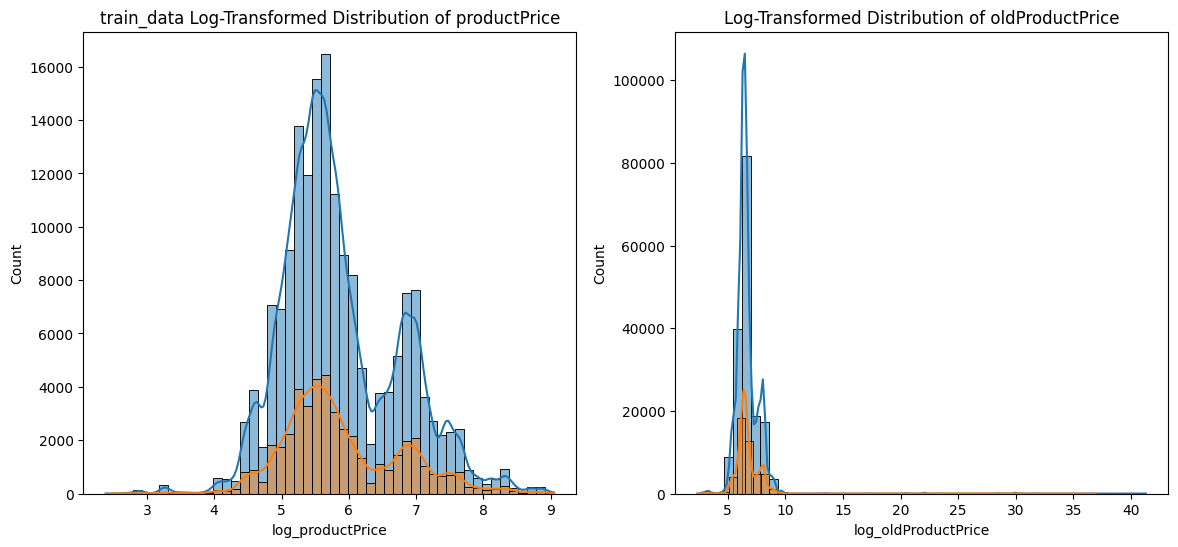

In [252]:
train_data['log_productPrice'] = np.log1p(train_data['productPrice'])
train_data['log_oldProductPrice'] = np.log1p(train_data['oldProductPrice'])

test_data['log_productPrice'] = np.log1p(test_data['productPrice'])
test_data['log_oldProductPrice'] = np.log1p(test_data['oldProductPrice'])

#let's visualize log transformed data

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(train_data['log_productPrice'], bins=50, kde=True)
plt.title('train_data Log-Transformed Distribution of productPrice')

plt.subplot(1, 2, 2)
sns.histplot(train_data['log_oldProductPrice'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of oldProductPrice')

plt.subplot(1, 2, 1)
sns.histplot(test_data['log_productPrice'], bins=50, kde=True)
plt.title('train_data Log-Transformed Distribution of productPrice')

plt.subplot(1, 2, 2)
sns.histplot(test_data['log_oldProductPrice'], bins=50, kde=True)
plt.title('Log-Transformed Distribution of oldProductPrice')

plt.show()

Looks much better 🔥 Old Price still has a tail, we can eliminate outliers maybe later.

# Categorie Features

Let's dive into the categories first. Earlier, we noticed that the categories are a mix of Turkish, English, Japanese, French, and other languages. Can we use them like that? Who’s going to convert them?

Well, we might be able to. Here’s my thought process on tackling this problem. 

* Word embedding can help with our category issue, especially if we use a model trained on multi-language data. This way, we can represent our categories as numerical arrays. The embedding will produce similar vectors for similar categories, even if they are in different languages.

* Implementing this with neural networks is straightforward. An embedding layer in TensorFlow before the dense layers will handle the conversion to arrays. This approach means that even if a new category is added in a different language or an error occurs, the system will still recognize and handle it effectively.

* Another solution is One-Hot encoding, which represents each category as a separate feature. This method is efficient for a small number of categories, but with a large number of categories like ours, we might need to use a translation layer to convert all categories into the same language and reduce the number of features.

* There’s also the option of taking the mean of the target value for each category. However, this approach can cause data leakage and make the evaluation less accurate.

* Label encoding is another method, but it can lead to one category being more important than others, which we want to avoid. But I did notice that there are main categories and subcategories. We could implement a system that labels the categories and suggests subcategories if a user visits a main category. This hierarchy can be managed with normalization techniques, but differences will still exist.

In [253]:
unique_categories = set()
df['category'].apply(lambda x: unique_categories.add(tuple(x)))
unique_arrays = [list(arr) for arr in unique_categories]
print("Benzersiz Array'ler:",len(unique_categories))
print(unique_arrays)


Benzersiz Array'ler: 250
[['kadın deri giyim', 'deri biker mont'], ['erkek çanta', 'evrak çantası'], ['женщина обувь'], ['erkek aksesuar', 'deri cüzdan'], ['accessoires femmes'], ['путешествие samsonite'], ['kadın ayakkabi', 'çizme'], ['kadın deri giyim', 'deri pardösü'], ['kadın deri giyim', 'deri yelek'], ['kadın deri giyim', 'deri etek'], ['erkek ayakkabı', 'terlik'], ['женщинам кожаная одежда'], ['남성 액세서리'], ['ayakkabi genel'], ['женщины кожа одежда', 'кожаная куртка'], ['ženy obuv'], ['seyahat samsonite', 'elbise çantası'], ['kadın deri giyim'], ['kadın ayakkabi', 'spor ayakkabı'], ['erkek ayakkabı', 'sandalet terlik'], ['seyahat american tourister', 'orta boy valiz'], ['erkek deri giyim', 'deri ceket'], ['kadin aksesuar', 'deri kartlık'], ['seyahat çocuk'], ['kisisellestirme urunleri'], ['seyahat indirim 1'], ['ταξίδια'], ['seyahat samsonite', 'aksesuar'], ['seyahat american tourister', 'kabin boy valiz'], ['kadin aksesuar', 'pasaportluk'], ['kadın ayakkabi', 'bot'], ['erkek akse

In [254]:
category_mapping = {
    'kadın ayakkabı': 'women\'s shoes',
    'erkek ayakkabı': 'men\'s shoes',
    'günlük ayakkabı': 'casual shoes',
    'sandalet': 'sandals',
    'kadın çanta': 'women\'s bags',
    'erkek deri giyim': 'men\'s leather clothing',
    'seyahat samsonite': 'travel samsonite',
    'deri ceket': 'leather jacket',
    'kadın deri giyim': 'women\'s leather clothing',
    'klasik ayakkabı': 'classic shoes',
    'omuz askılı çanta': 'shoulder bag',
    'spor ayakkabı': 'sports shoes',
    'deri cüzdan': 'leather wallet',
    'comfort': 'comfort',
    'deri mont': 'leather coat',
    'topuklu ayakkabı': 'high heels',
    'terlik': 'slippers',
    'erkek aksesuar': 'men\'s accessories',
    'kadın aksesuar': 'women\'s accessories',
    'seyahat american tourister': 'travel american tourister',
    'çocuk': 'children',
    'spor ayakkabı & sneaker': 'sports shoes & sneakers',
    'babet': 'ballet flats',
    'kabin boy valiz': 'cabin suitcase',
    'sırt çantası': 'backpack',
    'sepette 30 indirim': '30% discount in cart',
    'topuklu sandalet': 'high-heeled sandals',
    'loafer': 'loafers',
    'kadın': 'women',
    'erkek çanta': 'men\'s bags',
    'abiye': 'evening dress',
    'bot': 'boots',
    'orta boy valiz': 'medium suitcase',
    'el çantası': 'handbag',
    'deri kemer': 'leather belt',
    'deri kaban': 'leather coat',
    'firsat': 'opportunity',
    'büyük boy valiz': 'large suitcase',
    'seyahat çocuk': 'travel children',
    'laptop çantası': 'laptop bag',
    'clutch': 'clutch',
    'kadin aksesuar': 'women\'s accessories',
    'okul ayakkabilari': 'school shoes',
    'erkek': 'men',
    'bootie': 'booties',
    'evrak çantası': 'briefcase',
    'ayakkabi genel': 'general shoes',
    'postacı çantası': 'messenger bag',
    'okul çantası': 'school bag',
    'deri kartlık': 'leather cardholder',
    'deri pardösü': 'leather coat',
    'deri biker mont': 'leather biker jacket',
    'canta genel': 'general bags',
    'sandalet terlik': 'sandals & slippers',
    'stiletto': 'stiletto',
    'aksesuar': 'accessories',
    'davet koleksiyonu': 'invitation collection',
    'deri gömlek': 'leather shirt',
    'espadril': 'espadrilles',
    'seyahat lipault paris': 'travel lipault paris',
    'deri anahtarlık': 'leather keychain',
    '2019 ilkbahar yaz': '2019 spring summer',
    'deri etek': 'leather skirt',
    'kürk kaban': 'fur coat',
    'seyahat genel': 'general travel',
    'alışveriş çantası': 'shopping bag',
    'tablet çantası': 'tablet bag',
    'deri yelek': 'leather vest',
    'deri eldiven': 'leather gloves',
    'şemsiye': 'umbrella',
    'süet ceket': 'suede jacket',
    'bel çantası': 'waist bag',
    'basak burcu kadinlari': 'virgo women',
    'siyah beyaz': 'black and white',
    'kişiye özel ürünler aksesuar': 'personalized products accessories',
    'seyahat çantası': 'travel bag',
    'yaz renkleri': 'summer colors',
    'pasaportluk': 'passport holder',
    'fit deri ceket': 'fit leather jacket',
    'derigiyim genel': 'general leather clothing',
    'list': 'list',
    'bodrum sandaletleri': 'bodrum sandals',
    'deri elbise': 'leather dress',
    'bakım aksesuarları': 'care accessories',
    'kadın çantası': 'women\'s bags',
    'monogram': 'monogram',
    'aksesuar genel': 'general accessories',
    'kadin bot': 'women\'s boots',
    'çizme': 'boots',
    'deri pantolon': 'leather pants',
    'valiz': 'suitcase',
    'bluz': 'blouse',
    'telefon kılıfı': 'phone case',
    'women': 'women',
    'elbise çantası': 'dress bag',
    'orgu desenli urunler': 'knit patterned products',
    'egzotik desenler': 'exotic patterns',
    'erkek bot': 'men\'s boots',
    'мужчины': 'men',
    'seyahat': 'travel',
    'deri charm': 'leather charm',
    'nisan 20 indirim': 'april 20% discount',
    'deri isimlik': 'leather name tag',
    'anahtarlık': 'keychain',
    'ev aksesuarı': 'home accessories',
    'cizme': 'boots',
    'charm': 'charm',
    'makyaj çantası': 'makeup bag',
    'женщины': 'women',
    'en uzun gun': 'longest day',
    'women shoes': 'women\'s shoes',
    'men': 'men',
    'deri i̇simlik': 'leather name tag',
    'женщины обувь': 'women\'s shoes',
    '남성': 'men',
    'bakım aksesuarı': 'care accessories',
    'seyahat lipault paris valiz': 'travel lipault paris suitcase',
    'travel samsonite': 'travel samsonite',
    'женщины кожа одежда': 'women\'s leather clothing',
    'women handbags': 'women\'s handbags',
    'erkek deri isimlik': 'men\'s leather name tag',
    'women leather clothing': 'women\'s leather clothing',
    'kombin urunler': 'combination products',
    'erkek comfort': 'men\'s comfort',
    'moterys batai': 'women\'s shoes',
    'seyahat samsonite tras cantasi': 'travel samsonite toiletry bag',
    'kadin isimlik': 'women\'s name tag',
    '2018 kis koleksiyonu': '2018 winter collection',
    'men shoes': 'men\'s shoes',
    'moterys odiniai drabužiai': 'women\'s leather clothing',
    'aksesuar kadin deri isimlik': 'accessories women\'s leather name tag',
    'мужчины обувь': 'men\'s shoes',
    '여성': 'women',
    'moterys': 'women',
    'traş çantası': 'shaving bag',
    'marin esintisi': 'marine breeze',
    'γυναίκες': 'women',
    'moterys rankinės': 'women\'s handbags',
    '2019 sonbahar kis': '2019 autumn winter',
    'kadin ayakkabi': 'women\'s shoes',
    'женщины сумки': 'women\'s handbags',
    'aksesuar erkek deri isimlik': 'accessories men\'s leather name tag',
    'женщина': 'woman',
    'men handbags': 'men\'s handbags',
    '남성 가죽 의류': 'men\'s leather clothing',
    '10 indirim subat2019': '10% discount february 2019',
    'valeria kadın deri günlük ayakkabı': 'valeria women\'s leather casual shoes',
    '남성 액세서리': 'men\'s accessories',
    'homme chaussures': 'men\'s shoes',
    '여성 신발': 'women\'s shoes',
    'ženy obuv': 'women\'s shoes',
    'homme vêtements en': 'men\'s clothing',
    'женщинам обувь': 'women\'s shoes',
    'men leather clothing': 'men\'s leather clothing',
    'erkek ayakkabi': 'men\'s shoes',
    'women bags': 'women\'s bags',
    'handbag': 'handbag',
    'shoulder bag': 'shoulder bag',
    'seyahat indirim 1': 'travel discount 1',
    'большой размер чемодан': 'large suitcase',
    'mujeres zapatos': 'women\'s shoes',
    'kadin spor ayakkabi': 'women\'s sports shoes',
    'klein erkek deri bot': 'klein men\'s leather boots',
    'cestovanie deti': 'travel children',
    'hommes': 'men',
    'femei îmbrăcăminte': 'women\'s clothing',
    'men bags': 'men\'s bags',
    'moterys avalynė': 'women\'s shoes',
    'batai': 'shoes',
    'النساء الأحذية': 'women\'s shoes',
    'бабетта': 'babetta',
    'kadin bootie': 'women\'s booties',
    'путешествия samsonite': 'travel samsonite',
    'ταξίδια': 'travel',
    'kadin babet': 'women\'s ballet flats',
    'kisisellestirme urunleri': 'personalized products',
    'hommes sacs à main': 'men\'s handbags',
    'メンズ シューズ': 'men\'s shoes',
    'женщины аксессуары': 'women\'s accessories',
    'スポーツシューズ': 'sports shoes',
    'erkek loafer': 'men\'s loafers',
    'kadin clutch gece cantasi': 'women\'s clutch evening bag',
    'donna': 'women',
    'men accessories': 'men\'s accessories',
    'moterys priedai': 'women\'s accessories',
    'moterys aksesuarai': 'women\'s accessories',
    'bahar kombinleri': 'spring combinations',
    'accessoires femmes': 'women\'s accessories',
    'erkek spor ayakkabi': 'men\'s sports shoes',
    'زنان': 'women',
    'damen': 'women',
    'kadin deri giyim': 'women\'s leather clothing',
    'путешествие samsonite': 'travel samsonite',
    'خانمها کیف های دستی': 'women\'s handbags',
    'medium suitcase': 'medium suitcase',
    'женщина обувь': 'women\'s shoes',
    'женщинам кожаная одежда': 'women\'s leather clothing',
    'muhtesem uyum': 'perfect fit',
    '女装 鞋子': 'women\'s shoes',
    'erkek sandalet': 'men\'s sandals',
    'aksesuar kadin deri cuzdan': 'women\'s leather wallet accessories',
    '샌들': 'sandals',
    'кожаная куртка': 'leather jacket',
    'travel children': 'travel children',
    'leather skirt': 'leather skirt',
    'travel american tourister': 'travel american tourister',
    '여행 삼소 나이트': 'travel samsonite',
    'yengec burcu': 'cancer zodiac sign',
    'accessories': 'accessories'}


In [255]:
def translate_categories(categories, mapping):
    return [mapping.get(cat, cat) for cat in categories]

# Kategorileri çevirme
test_data['category'] = test_data['category'].apply(lambda x: translate_categories(x, category_mapping))
train_data['category'] = train_data['category'].apply(lambda x: translate_categories(x, category_mapping))

df['category'] = df['category'].apply(lambda x: translate_categories(x, category_mapping))

/tmp/ipykernel_33/1937021324.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['category'] = test_data['category'].apply(lambda x: translate_categories(x, category_mapping))
/tmp/ipykernel_33/1937021324.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['category'] = train_data['category'].apply(lambda x: translate_categories(x, category_mapping))


# Lets do one hot encoding for the unique category 

Note: I am going to skip this part, I will not do one hot encoding. Please do not run the following code block

In [256]:
""" from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
# Kategorileri one-hot encode etme
print("OneHotEncoder'ı fit etme...")
categories = df['category'].explode().unique().tolist()
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoder.fit(pd.DataFrame(categories, columns=['category']))
print("OneHotEncoder fit işlemi tamamlandı.")

# tqdm ile progress bar kullanma
tqdm.pandas(desc="Kategorileri encode etme")

# Her bir session için kategorileri one-hot encode etme ve birleştirme
def encode_categories(categories):
    if not categories:  # Eğer kategori boş ise
        return np.zeros(one_hot_encoder.categories_[0].shape[0])
    encoded = one_hot_encoder.transform(pd.DataFrame(categories, columns=['category']))
    return encoded.sum(axis=0)

print("Kategorileri encode etmeye başlama...")
df['one_hot_encoded'] = df['category'].progress_apply(encode_categories)
print("Kategorilerin encode işlemi tamamlandı.")

# One-hot encoded özellikleri ayrı sütunlara ayırma
encoded_df = pd.DataFrame(df['one_hot_encoded'].tolist(), columns=one_hot_encoder.get_feature_names_out(['category']))
df = pd.concat([df.drop(columns=['one_hot_encoded', 'category']), encoded_df], axis=1)
print("One-Hot Encoded DataFrame:")
df """

' from sklearn.preprocessing import OneHotEncoder\nfrom tqdm import tqdm\n# Kategorileri one-hot encode etme\nprint("OneHotEncoder\'ı fit etme...")\ncategories = df[\'category\'].explode().unique().tolist()\none_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown=\'ignore\')\none_hot_encoder.fit(pd.DataFrame(categories, columns=[\'category\']))\nprint("OneHotEncoder fit işlemi tamamlandı.")\n\n# tqdm ile progress bar kullanma\ntqdm.pandas(desc="Kategorileri encode etme")\n\n# Her bir session için kategorileri one-hot encode etme ve birleştirme\ndef encode_categories(categories):\n    if not categories:  # Eğer kategori boş ise\n        return np.zeros(one_hot_encoder.categories_[0].shape[0])\n    encoded = one_hot_encoder.transform(pd.DataFrame(categories, columns=[\'category\']))\n    return encoded.sum(axis=0)\n\nprint("Kategorileri encode etmeye başlama...")\ndf[\'one_hot_encoded\'] = df[\'category\'].progress_apply(encode_categories)\nprint("Kategorilerin encode işlemi 

# One-Hot Encoding vs. Word Embeddings

One-hot encoding is a method we can use, but it gets expensive as the number of categories increases. In our case, the categories can become quite numerous. Since we've translated all the categories to English, we can use Word2Vec to get the embedding versions of each category, which is more computationally efficient.

Let's represent the related categories with word embeddings. I am not adding this data to my data since I might not implement NN for this case study.

In [257]:
from gensim.models import Word2Vec

In [258]:
sentences = df['category'].tolist()
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save model if needed
word2vec_model.save("word2vec.model")

In [259]:
def get_embedding(categories):
    embeddings = [word2vec_model.wv[cat] for cat in categories if cat in word2vec_model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

df['category'].apply(get_embedding)

89001     [-0.14899698, 0.18123107, 0.04276596, 0.653891...
54243     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
54220     [-0.45856053, 0.45136344, 0.46786043, 0.576126...
54230     [-0.45856053, 0.45136344, 0.46786043, 0.576126...
54239     [-0.45856053, 0.45136344, 0.46786043, 0.576126...
                                ...                        
114202    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
114201    [-0.08477336, 0.052746292, -0.31271768, -0.247...
114203    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
114204    [-0.4956282, 0.005546332, -0.594329, -0.051472...
199918    [-0.03307205, 0.051958356, 0.33815113, 0.93354...
Name: category, Length: 691842, dtype: object

Note Grouping Code Below is not use for the ML integration, but still I want to show you that what kind of other features can be generated. I have tested and found out that the model has higher performance without grouping it. For the simplicity and time I just not use grouping related data but these might helpful if we use other type of model architecture maybe. Also in the feature we can add these features to the model to understand the item based features and user based features .

In [260]:
def aggregate_embeddings(embeddings):
    return np.mean(embeddings, axis=0)

grouped_train_data =train_data.groupby(['userId', 'itemId']).agg({
    'date': list,
    'sessionId': 'first',
    'productPrice': 'mean',
    'oldProductPrice': 'mean',
    'category': lambda x: list(set([cat for sublist in x for cat in sublist])),
    #'embedding': lambda x: aggregate_embeddings(x.tolist()),
     #**{col: 'sum' for col in one_hot_encoder_pageType.get_feature_names_out(['pageType'])}
}).reset_index()

grouped_test_data = test_data.groupby(['userId', 'itemId']).agg({
    'date': list,
    'sessionId': 'first',
    'productPrice': 'mean',
    'oldProductPrice': 'mean',
    'category': lambda x: list(set([cat for sublist in x for cat in sublist])),
    #'embedding': lambda x: aggregate_embeddings(x.tolist()),
     #**{col: 'sum' for col in one_hot_encoder_pageType.get_feature_names_out(['pageType'])}
}).reset_index()

In [261]:
grouped_test_data['session_duration_minutes'] = grouped_test_data['date'].apply(lambda x: (pd.to_datetime(max(x)) - pd.to_datetime(min(x))).total_seconds() / 60)
grouped_train_data['session_duration_minutes'] = grouped_train_data['date'].apply(lambda x: (pd.to_datetime(max(x)) - pd.to_datetime(min(x))).total_seconds() / 60)

In [262]:
#session_data['events'] = session_data.apply(lambda row: list(zip(row['date'], row['pageType'])), axis=1)


In [263]:
#this cannot be added to the model since this might lead to dataleak

#session_data['has_success'] = session_data['pageType'].apply(lambda x: 'success' in x)

In [264]:
grouped_test_data['session_count'] = grouped_test_data.groupby('userId')['userId'].transform('count')
grouped_train_data['session_count'] = grouped_train_data.groupby('userId')['userId'].transform('count')

grouped_test_data['avg_product_price'] = grouped_test_data['productPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)
grouped_train_data['avg_old_product_price'] = grouped_train_data['oldProductPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)

grouped_test_data['avg_product_price'] = grouped_test_data['productPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)
grouped_train_data['avg_old_product_price'] = grouped_train_data['oldProductPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)


/tmp/ipykernel_33/3771934733.py:4: RuntimeWarning: Mean of empty slice
  grouped_test_data['avg_product_price'] = grouped_test_data['productPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)
/tmp/ipykernel_33/3771934733.py:5: RuntimeWarning: Mean of empty slice
  grouped_train_data['avg_old_product_price'] = grouped_train_data['oldProductPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)
/tmp/ipykernel_33/3771934733.py:7: RuntimeWarning: Mean of empty slice
  grouped_test_data['avg_product_price'] = grouped_test_data['productPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)
/tmp/ipykernel_33/3771934733.py:8: RuntimeWarning: Mean of empty slice
  grouped_train_data['avg_old_product_price'] = grouped_train_data['oldProductPrice'].apply(lambda prices: np.nanmean(prices) if prices else np.nan)


In [265]:
def calculate_discount_rate(old_price, new_price):
    if pd.notnull(old_price) and pd.notnull(new_price) and old_price > 0:
        discount_rate = (old_price - new_price) / old_price
        return round(discount_rate, 3)
    else:
        return np.nan

# Apply the function row by row
grouped_test_data['discount_rates'] = grouped_test_data.apply(
    lambda row: calculate_discount_rate(row['oldProductPrice'], row['productPrice']), axis=1
)

grouped_train_data['discount_rates'] = grouped_train_data.apply(
    lambda row: calculate_discount_rate(row['oldProductPrice'], row['productPrice']), axis=1
)

In [266]:
#note to me: N-grams can be helpful for more advanced feature selection, since the categories are paired.

Alright, we’ve handled the items, but we still have missing price values (NaN) in some rows. Instead of leaving these as NaNs, we can :

1. assign them a value of mean for now to keep things moving. However, there are better ways to handle this.

2. Another option is to first check if there are other entries in the data with the same `itemId` that do have price values. If such entries exist, we can use those prices to fill in the missing values. This approach ensures we’re using realistic data and maintaining the integrity of our dataset.

3. Or we can fill this values according to the distrubition that we have seen before to make it closer to normal distribution

But for our case, for the entries which has ItemId but not price value, assigning 'oldProductPrice', 'productPrice'  mean values or 0 might cause noise and this decrease the performance of our model. Second option is the best solution for now. But for the rest we can ignore those columns while handling it. We will get the data of interaction for that user with the item later in this case.


In [267]:
#grouped_df.loc[:, "oldProductPrice"] = grouped_df["oldProductPrice"].apply(lambda x: 0 if pd.isna(x) else x)
#grouped_df.loc[:, "productPrice"] = grouped_df["productPrice"].apply(lambda x: 0 if pd.isna(x) else x)
#grouped_df.loc[:, "avg_old_product_price"] = grouped_df["oldProductPrice"].apply(lambda x: 0 if pd.isna(x) else x)
#grouped_df.loc[:, "avg_product_price"] = grouped_df["productPrice"].apply(lambda x: 0 if pd.isna(x) else x)


# Model Training

**In this section, we will train our model using data grouped by userId and itemId. Our goal is to recommend items to a user within a session based on their past interactions. To achieve this, we need to create a model that can understand and learn the relationship between users and items, incorporating additional user data and item attributes.**

- User Data: This includes information such as session duration, session count, and purchased items.
- Item Data: This includes attributes such as category, discount rate, price range, and other relevant features.

By training the model on these features, we enable it to make accurate and personalized recommendations for users based on their historical interactions and the characteristics of the items.


While I was researching recommendation systems I was encounter with different type of recommendation systems.

1 - Machine Learnign Classification

2 - Deep Neural Network

3 - Collaborative Filtering: Matrix Factorization


As an ML Engineer, I would like to try different approaches and evaluate the pros and cons of the models. But due to lack of time, I try t implement as much as I can but no worries I will explain the methods that I try the ones that I can implement in a limited time.


1 - Machine Learnign Classification : I implement 2 different modern machine learning approaches. One is Xgboost and the other one is Random Forest. These models can provide good accuracy with a limited number of classes. To increase the accuracy with increasing the number of classes which is unique ItemId in our case we need to have either more complex model, maybe more deep in these 2 models ore more input data for every classes which is items.


2 - Deep Neural Network : We can also use Deep network for our model to understand more complex relation from our data. But the benefit of using Deep Neural Network is not just that. Categories as we shown prewious part can be a  problem. In the feature engineering and EDA part we have seen that there are more tha 150 classes even though we made the translation. Label encoding is the easy solution but we should not make one category more dominant to another by just assigning random variable. One-hot encoding is one solution but it is not effective when we have nearly 150 cleaned and translated categories. It will costly both to us and to the model.

But what we can do is to solve the problem we can create an embeding for these categories.

What is embedding ? 

With embeddign we can represent words (categories in numerical solutions) as vectors. In addition to we can represent the same categories or close ones with similar vectors in vector space. So that our recommendation model will be able to capture the concept between categories. For example one user has category ["kadın","ruj"] and the other category might be ["makyaj"]. So our model can understend the concept between those 2 categories and recomment the similar products to each other.

One other benefit can be using LSTM architectures since we worked a continuous time data.

3-) Collaborative Filtering: Matrix Factorization : According to my research this is one of the hot topics in recommendation systems It models user-item interactions by assuming latent vector representations for each user and item. Probabilistic Matrix Factorization (PMF) uses these representations to minimize a regularized MSE loss over known interactions, solved via methods like stochastic gradient descent (SGD) or alternating least squares (ALS).

But than I told my self the model not should be just interaction count with the item. We have a lot of data that might let client to success.For example the discount amount, the prices, the number of time that the user checks the item and more.

So after reasearching more I found a Hhybrid Approach that both Matrix Factorization and other additionalfeatures can use : **LightFM**, will be our main model that we are going to use in this case.


# LightFM Implementation

In [268]:
!pip install lightfm

In [269]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.data import Dataset
from sklearn.model_selection import train_test_split



In [270]:

# Ensure the category column is correctly formatted as a list of categories
test_data['category'] = test_data['category'].apply(lambda x: eval(x) if isinstance(x, str) else x)
train_data['category'] = train_data['category'].apply(lambda x: eval(x) if isinstance(x, str) else x)


# Extract unique users and items
unique_users = df['userId'].unique()
unique_items = df['itemId'].unique()

#unique_users: ['user1', 'user2', 'user3']
#unique_items: ['itemA', 'itemB', 'itemC']

# Create a mapping of userId and itemId to indices
user_mapping = {user: idx for idx, user in enumerate(unique_users)}
item_mapping = {item: idx for idx, item in enumerate(unique_items)}

#user_mapping: {'user1': 0, 'user2': 1, 'user3': 2}
#item_mapping: {'itemA': 0, 'itemB': 1, 'itemC': 2}

# Map the userId and itemId to indices
train_data['user_idx'] = train_data['userId'].map(user_mapping)
train_data['item_idx'] = train_data['itemId'].map(item_mapping)

test_data['user_idx'] = test_data['userId'].map(user_mapping)
test_data['item_idx'] = test_data['itemId'].map(item_mapping)


""" 
Interaction matrices represent the interactions between users 
and items (e.g., clicks, purchases). These matrices show which user
has interacted with which item and are used for model training.

Using sparse matrices in COO (Coordinate List) format allows for efficient
storage of interactions in memory. Sparse matrices are highly efficient for 
working with large datasets because they only store non-zero values.

"""

train_interaction_matrix = coo_matrix(
    (np.ones(train_data.shape[0]), (train_data['user_idx'], train_data['item_idx'])),
    shape=(len(unique_users), len(unique_items))
)

# np.ones(train_data.shape[0])
# Bu ifade, train_data veri setindeki her bir etkileşim için 1 değeri üretir.
# Bu, her etkileşimin (örneğin, bir tıklama veya satın alma) varlığını belirtir.

#(train_data['user_idx'], train_data['item_idx'])

#Eğer bir kullanıcı herhangi bir ürünle etkileşime girmemişse, 
#yani user_idx'in karşısında hiçbir item_idx yoksa, bu durumda 
#etkileşim matrisinde bu kullanıcı için hiçbir giriş olmayacaktır.
#Bu, sparse (seyrek) matrislerin doğasında olan bir özelliktir ve bu 
#durum verinin modelle işlenmesinde herhangi bir sorun yaratmaz.

#örnek Kullanıcı 1, öğe A ve öğe B ile etkileşime girmiş.
#Kullanıcı 2, hiçbir öğe ile etkileşime girmemiş.
#Kullanıcı 3, öğe C ile etkileşime girmiş.

#(0, 0)  1.0  # Kullanıcı 1, öğe A
#(0, 1)  1.0  # Kullanıcı 1, öğe B
#(2, 2)  1.0  # Kullanıcı 3, öğe C

#Kullanıcı 2'nin hiçbir öğe ile etkileşime girmediği için sparse matriste bir kaydı yoktur.


test_interaction_matrix = coo_matrix(
    (np.ones(test_data.shape[0]), (test_data['user_idx'], test_data['item_idx'])),
    shape=(len(unique_users), len(unique_items))
)


/tmp/ipykernel_33/1871787789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['category'] = test_data['category'].apply(lambda x: eval(x) if isinstance(x, str) else x)
/tmp/ipykernel_33/1871787789.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['category'] = train_data['category'].apply(lambda x: eval(x) if isinstance(x, str) else x)
/tmp/ipykernel_33/1871787789.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [271]:
# Extract all unique categories
all_categories = set([cat for sublist in df['category'] for cat in sublist])

# Initialize LightFM Dataset and fit with users, items, and item features (categories)
dataset = Dataset()
dataset.fit(
    users=unique_users,
    items=unique_items,
    item_features=all_categories
)

#train_data = grouped_train_data
#test_data = grouped_test_data

train_interactions, _ = dataset.build_interactions(
    ((row['userId'], row['itemId']) for idx, row in train_data.iterrows())
)


# **Note** : 
For simplicity, I've only added one feature here. However, many more features can be added to help the model better understand the relationships between users with similar behaviors and the item features they interact with.




In [272]:
# Build item features

item_features = dataset.build_item_features(
    ((row['itemId'], row['category']) for idx, row in df.iterrows())
)


In [273]:
# Create and train the model
model = LightFM(loss='warp')
model.fit(train_interactions, item_features=item_features, epochs=30, num_threads=4)


In [274]:
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

# Build interactions for test
test_interactions, _ = dataset.build_interactions(
    ((row['userId'], row['itemId']) for idx, row in test_data.iterrows())
)

# Calculate evaluation metrics
precision = precision_at_k(model, test_interactions, train_interactions=train_interactions, 
                           item_features=item_features, k=10).mean()
recall = recall_at_k(model, test_interactions, train_interactions=train_interactions, 
                     item_features=item_features, k=10).mean()
auc = auc_score(model, test_interactions, train_interactions=train_interactions, 
                item_features=item_features).mean()

print(f"Precision@10: {precision:.4f}")
print(f"Recall@10: {recall:.4f}")
print(f"AUC: {auc:.4f}")


Precision@10: 0.0859
Recall@10: 0.1658
AUC: 0.8743


In [275]:
import pickle

# Modeli kaydet
with open('lightfm_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Kullanıcı ve öğe mapping'lerini kaydet
with open('user_mapping.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)

with open('item_mapping.pkl', 'wb') as f:
    pickle.dump(item_mapping, f)

# Öğe özelliklerini kaydet
with open('item_features.pkl', 'wb') as f:
    pickle.dump(item_features, f)


In [276]:
# Modeli yükle
with open('lightfm_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Kullanıcı ve öğe mapping'lerini yükle
with open('user_mapping.pkl', 'rb') as f:
    user_mapping = pickle.load(f)

with open('item_mapping.pkl', 'rb') as f:
    item_mapping = pickle.load(f)

# Öğe özelliklerini yükle
with open('item_features.pkl', 'rb') as f:
    item_features = pickle.load(f)


In [277]:
def recommend_user(model, user_id, user_mapping, item_mapping, item_features, top_n=10):
    user_idx = user_mapping.get(user_id, None)
    if user_idx is None:
        raise ValueError(f"User ID {user_id} not found in user mapping.")
    
    item_indices = np.arange(len(item_mapping))
    scores = model.predict(user_idx, item_indices, item_features=item_features)
    top_items = np.argsort(-scores)[:top_n]
    
    reverse_item_mapping = {v: k for k, v in item_mapping.items()}
    recommendations = [reverse_item_mapping[item] for item in top_items]
    return recommendations

# Örnek kullanım
user_id = '00172f1d9a71e9a8de0aa34288a6b19b'
recommendations = recommend_user(model, user_id, user_mapping, item_mapping, item_features)
print(f"Recommendations for user {user_id}: {recommendations}")


Recommendations for user 00172f1d9a71e9a8de0aa34288a6b19b: [nan, '5bd2d8fd858558068f8e8ad2014698c9', '7ed2d723beced894d258eade0291a5db', '18fab2a69ffeb1107340fd61feb87e95', '9d81e59d62f8ae8f69f0a9f2c8d41f98', '61f0ea9de15676b0dc2cdde6105e2eee', '0a52e9d93b11ead292b7d8e32b6dc842', 'dacee7733dbf727d596b01ec46815f1a', '40b53d7f46a321dad8bf78cc8273b646', '743d1517be83f769046e7852aa70bcc0']


# Conclusion





# Thank You for Reading Till the End!

## Quick Summary of What We've Done:

### First Part: Data Loading and Basic Evaluation
- Loaded the training data.
- Performed basic evaluations using `.describe()` and `.info()` to understand the initial structure and summary statistics of the dataset.

### Second Part: Exploratory Data Analysis (EDA)
- Took a deep dive into the data to better understand it.
- Performed EDA to visualize the data and check its distribution.

### Third Part: Feature Engineering and ETL
- Conducted feature engineering and ETL (Extract, Transform, Load) operations to create more meaningful features for our model.

### Fourth Part: Model Training
- Discussed and experimented with different methods for recommendation.

## Methods Explored:

1. **Classical Machine Learning Methods**: (xgboost & random forest)
   - Initially tried using classical machine learning methods to classify items based on user and item behaviors.
   - Realized that these methods might not be the best for recommendations as they require significant computational power and resources.
   - The increasing number of unique items leads to a performance bottleneck due to the rising number of classes.
   - However, these methods are straightforward to implement.

2. **Neural Networks**:
   - Considered creating a neural network, which could be promising for recommendations.
   - Due to time constraints, this method was not implemented in this project.
   - Neural networks can be easily implemented by adding categories as embedding vectors, along with the features created during feature engineering.

3. **LightFM**:
   - Implemented LightFM, a hybrid solution that learns the relationship between user-item interactions and user-specific and item-specific features.
   - Found many resources but need more research to fully understand the library and its workings.
   - Focused on data visualization, meaning, and feature engineering as indicated by the case study.

## Evaluation Metrics:

- **Precision@10**: 0.0853
- **Recall@10**: 0.1660
- **AUC**: 0.8707

These metrics suggest that while our Precision and Recall values are not very high, the AUC indicates that our model performs well in distinguishing between relevant and non-relevant items.

The one reason to have an outcome like this might be since we are testing the model with new unseen users. For existing user the metrics can be higher.

## Suggestions for Improvement:

- **Evaluate Training and Test Data**: Assess whether more data is needed.
- **Deep Dive To LightFM: Learning the advance working of LightFM and oprimize the hyperparameters, model structure and more
- **More Features Can be added**: more user and item features so the LightFM model can better understand the relationships.
- **Neural Network Implementation**: Implementing a neural network with embedding vectors for categories in the future.
- **Further Research**: Conduct more research to fully understand LightFM and its potential.

## Next Steps and Gratitude

- I've truly enjoyed working on this project and sharing the journey with you. 

- I'm eager to dive deeper into this field, experiment with advanced methods, and explore new techniques to enhance recommendation systems. There’s always more to learn and discover, and I’m excited about the potential improvements and innovations ahead.

- Thank you for taking the time to read through this project! Your feedback and suggestions are greatly appreciated and always welcome.









---------------------------------------------------

In [278]:
"""from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combined_y = np.concatenate([y_train, y_test])
le.fit(combined_y)

# Transform y_train and y_test
y_train = le.transform(y_train)
y_test = le.transform(y_test)
"""

'from sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ncombined_y = np.concatenate([y_train, y_test])\nle.fit(combined_y)\n\n# Transform y_train and y_test\ny_train = le.transform(y_train)\ny_test = le.transform(y_test)\n'

In [279]:
"""import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
model.fit(X_train, y_train)
"""

"import xgboost as xgb\nfrom sklearn.metrics import accuracy_score, classification_report\n\nmodel = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')\n\n# Train the model\nmodel.fit(X_train, y_train)\n"

In [280]:
"""from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = model.predict(X_test)
y_pred = le.inverse_transform(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)"""

'from sklearn.metrics import confusion_matrix, accuracy_score\ny_pred = model.predict(X_test)\ny_pred = le.inverse_transform(y_pred)\ncm = confusion_matrix(y_test, y_pred)\nprint(cm)\naccuracy_score(y_test, y_pred)'

In [281]:
"""batch_size = 5000
iterations = 2
model = None
for i in range(iterations):
    for start in range(0, len(X_train), batch_size):
        end = start + batch_size
        if end > len(X_train):
            end = len(X_train)
        
        dtrain = xgb.DMatrix(X_train[start:end], label=y_train[start:end])
        
        model = xgb.train({
    'learning_rate': 0.1,
    'max_depth': 8,
    'min_child_weight': 1,
    'gamma': 0.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob',
    'num_class': len(le.classes_),
    'reg_alpha': 1,
    'reg_lambda': 1,
    'verbosity': 2
}, dtrain=dtrain, xgb_model=model)
        
        # Make predictions
        dtest = xgb.DMatrix(X_test)
        y_pr = model.predict(dtest)
        
        # Convert predictions to class labels
        y_pr_class = np.argmax(y_pr, axis=1)
        print(y_pr_class)
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pr_class)
        print(f'Iteration {i + 1}, Batch {int(start / batch_size) + 1}, Accuracy: {accuracy:.4f}')
"""

"batch_size = 5000\niterations = 2\nmodel = None\nfor i in range(iterations):\n    for start in range(0, len(X_train), batch_size):\n        end = start + batch_size\n        if end > len(X_train):\n            end = len(X_train)\n        \n        dtrain = xgb.DMatrix(X_train[start:end], label=y_train[start:end])\n        \n        model = xgb.train({\n    'learning_rate': 0.1,\n    'max_depth': 8,\n    'min_child_weight': 1,\n    'gamma': 0.0,\n    'subsample': 0.8,\n    'colsample_bytree': 0.8,\n    'objective': 'multi:softprob',\n    'num_class': len(le.classes_),\n    'reg_alpha': 1,\n    'reg_lambda': 1,\n    'verbosity': 2\n}, dtrain=dtrain, xgb_model=model)\n        \n        # Make predictions\n        dtest = xgb.DMatrix(X_test)\n        y_pr = model.predict(dtest)\n        \n        # Convert predictions to class labels\n        y_pr_class = np.argmax(y_pr, axis=1)\n        print(y_pr_class)\n        # Calculate accuracy\n        accuracy = accuracy_score(y_test, y_pr_class)

-----------------------

In [282]:
"""from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)"""


'from sklearn.ensemble import RandomForestClassifier\n\n# Initialize the model\nmodel = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Train the model\nmodel.fit(X_train, y_train)'

In [283]:
"""y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)"""

'y_pred = model.predict(X_test)\n\n# Evaluate the model\naccuracy = accuracy_score(y_test, y_pred)\nreport = classification_report(y_test, y_pred)\n\nprint(f"Model Accuracy: {accuracy:.2f}")\nprint("Classification Report:")\nprint(report)'